# Visualise the Tracked Marine Heatwaves

In [1]:
import xarray as xr
import numpy as np
import dask
from getpass import getuser
from pathlib import Path

import spot_the_blOb.helper as hpc
from spot_the_blOb.plotter import *

from matplotlib.colors import ListedColormap

In [2]:
# Start Dask Cluster
client = hpc.StartLocalCluster(n_workers=32, n_threads=4)

Memory per Worker: 15.74 GB


/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33349 instead
  warnings.warn(


Hostname is  l40225
Forward Port = l40225:33349
Dashboard Link: localhost:33349/status


In [3]:
# Import Tracked MHW DataSet

file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'MHWs_tracked_subset.nc'
blobs_ds = xr.open_dataset(file_name, chunks={'time': 10, 'lat': 400, 'lon': 400, 'ID': 200, 'merge_ID': 200, 'component':-1, 'parent_idx':-1, 'child_idx':-1})
blobs_ds

<xarray.Dataset> Size: 4GB
Dimensions:              (lat: 721, lon: 1440, time: 1000, ID: 886,
                          component: 2, merge_ID: 2074, parent_idx: 7,
                          child_idx: 7)
Coordinates:
  * lat                  (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.75 90.0
  * lon                  (lon) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * time                 (time) datetime64[ns] 8kB 2002-01-01T23:59:00 ... 20...
  * ID                   (ID) int32 4kB 1 2 3 4 5 6 ... 881 882 883 884 885 886
Dimensions without coordinates: component, merge_ID, parent_idx, child_idx
Data variables: (12/13)
    ID_field             (time, lat, lon) int32 4GB dask.array<chunksize=(10, 400, 400), meta=np.ndarray>
    global_ID            (time, ID) int32 4MB dask.array<chunksize=(10, 200), meta=np.ndarray>
    area                 (time, ID) float32 4MB dask.array<chunksize=(10, 200), meta=np.ndarray>
    centroid             (component, time, ID) float32 7MB dask.array<chunksize=(2, 10, 200), meta=np.ndarray>
    presence             (time, ID) bool 886kB dask.array<chunksize=(10, 200), meta=np.ndarray>
    time_start           (ID) datetime64[ns] 7kB dask.array<chunksize=(200,), meta=np.ndarray>
    ...                   ...
    merge_parent_IDs     (merge_ID, parent_idx) int32 58kB dask.array<chunksize=(200, 7), meta=np.ndarray>
    merge_child_IDs      (merge_ID, child_idx) int32 58kB dask.array<chunksize=(200, 7), meta=np.ndarray>
    merge_overlap_areas  (merge_ID, parent_idx) int32 58kB dask.array<chunksize=(200, 7), meta=np.ndarray>
    merge_time           (merge_ID) datetime64[ns] 17kB dask.array<chunksize=(200,), meta=np.ndarray>
    merge_n_parents      (merge_ID) int8 2kB dask.array<chunksize=(200,), meta=np.ndarray>
    merge_n_children     (merge_ID) int8 2kB dask.array<chunksize=(200,), meta=np.ndarray>
Attributes:
    allow_merging:           1
    N_blobs_unfiltered:      23004
    N_blobs_final:           885
    R_fill:                  8
    area_filter_quartile:    0.5
    area_threshold:          838.0
    rejected_area_fraction:  0.0838395106066188
    accepted_area_fraction:  0.9161604893933812
    overlap_threshold:       0.5
    nn_partitioning:         1
    total_merges:            2074
    multi_parent_merges:     514

In [4]:
# Extract the MHW ID Field

blobs = blobs_ds.ID_field
blobs

<xarray.DataArray 'ID_field' (time: 1000, lat: 721, lon: 1440)> Size: 4GB
dask.array<open_dataset-ID_field, shape=(1000, 721, 1440), dtype=int32, chunksize=(10, 400, 400), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 8kB 2002-01-01T23:59:00 ... 2004-09-26T23:...

## Plot some Blobby Shapes (1 Each Month)

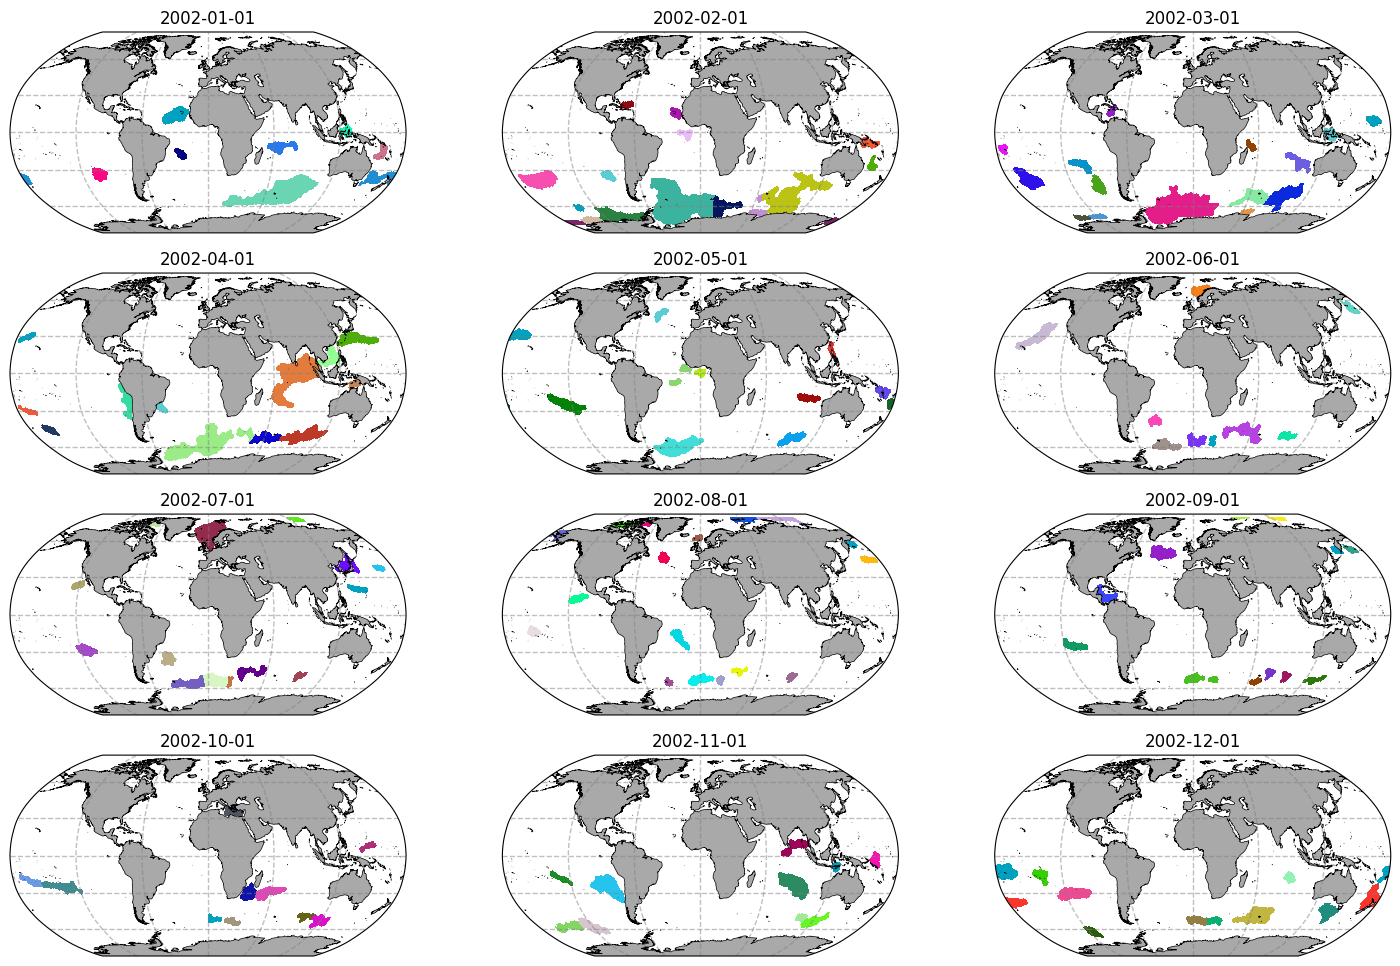

In [5]:
cm = ListedColormap(np.random.random(size=(int(1e5), 3)).tolist())

blobs_day1 = blobs.sel(time=slice('2002-01-01', '2002-12-31')).resample(time='MS').first().persist()
blobs_day1 = blobs_day1.where(blobs_day1>0)
fig, ax = blobs_day1.plotter.pplot_col(col_wrap=3, var_units='MHW ID', cmap=cm, show_colorbar=False, cperc=[0, 100])


## Plot consecutive Daily Blobby Shapes

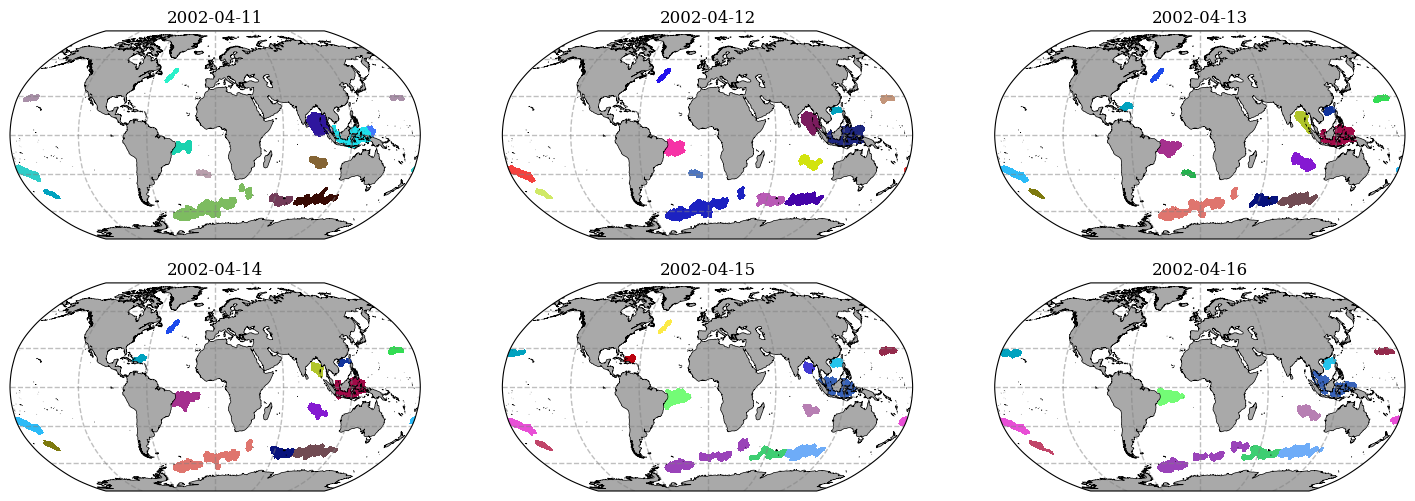

In [7]:
blobbys = blobs.isel(time=slice(100,106)).persist()
blobbys = blobbys.where(blobbys>0)
fig, ax = blobbys.plotter.pplot_col(col_wrap=3, var_units='MHW ID', cmap=cm, show_colorbar=False, cperc=[0, 100])

## Global Blob Frequency

(<Figure size 700x500 with 2 Axes>, <GeoAxes: >)

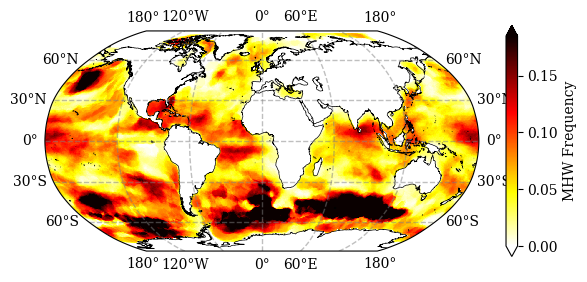

In [ ]:
event_frequency = (blobs > 0).astype(float).mean('time')
fig, ax = event_frequency.plotter.pplot(var_units='MHW Frequency', cmap='hot_r', cperc=[0,96])

## Find & Plot a Few of the Longest Events

In [9]:
events_duration = blobs_ds.time_end - blobs_ds.time_start
longest_events = events_duration.sortby(events_duration, ascending=False).ID

for ID in longest_events[:10].values:
    print(f"ID: {ID}, Start Day: {blobs_ds.time_start.sel(ID=ID).dt.strftime('%Y-%m-%d').values}, Duration: {events_duration.sel(ID=ID).dt.days.values} days")

ID: 886, Start Day: 2002-01-01, Duration: 999 days
ID: 8, Start Day: 2002-01-01, Duration: 999 days
ID: 7, Start Day: 2002-01-01, Duration: 999 days
ID: 399, Start Day: 2003-03-31, Duration: 294 days
ID: 9, Start Day: 2002-01-02, Duration: 286 days
ID: 531, Start Day: 2003-08-15, Duration: 218 days
ID: 272, Start Day: 2002-11-11, Duration: 196 days
ID: 1, Start Day: 2002-01-01, Duration: 193 days
ID: 242, Start Day: 2002-10-14, Duration: 191 days
ID: 629, Start Day: 2003-12-05, Duration: 151 days


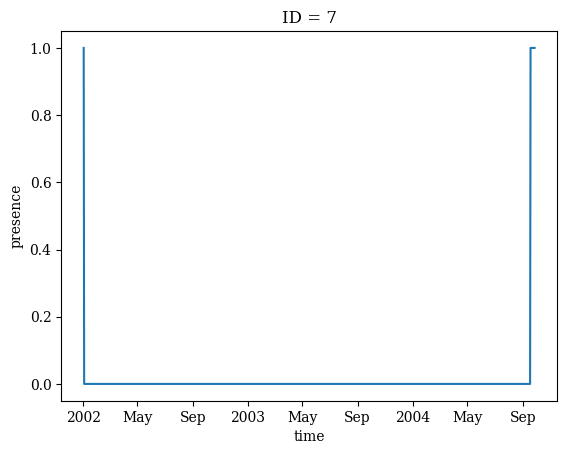

In [28]:
blobs_ds.sel(ID=7).presence.plot()

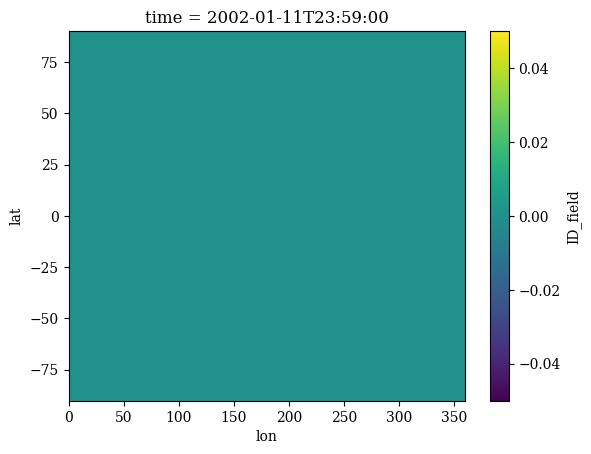

In [22]:
blobs0 = xr.where(blobs>0, blobs, 0)
(blobs0 == 886).isel(time=10).plot()

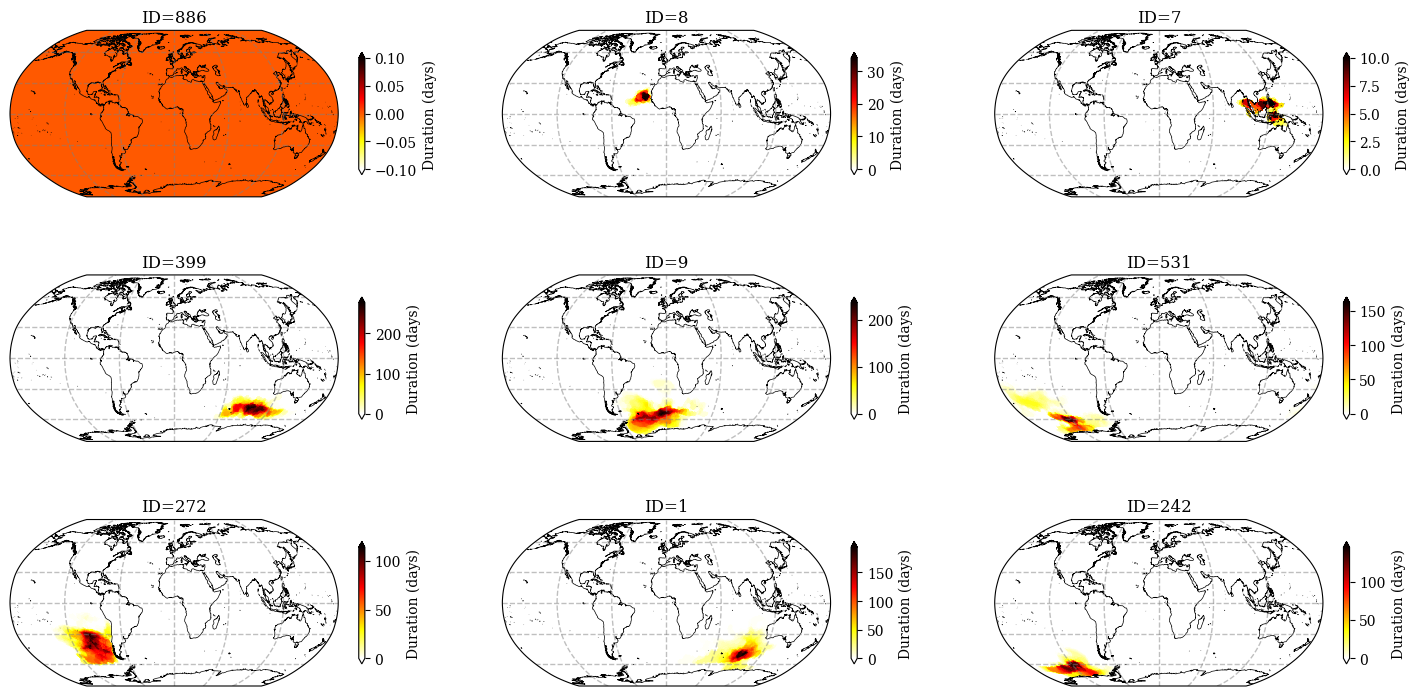

In [12]:
long_blobs = blobs == (longest_events[:9]).chunk({'ID':1})
long_blobs_local_duration = (long_blobs > 0).sum('time')

fig, ax = long_blobs_local_duration.plotter.pplot_col(col='ID', col_wrap=3, var_units='Duration (days)', cmap='hot_r', cperc=[0, 100])

## Time-Series Plot of Events Area

In [ ]:
events_areas = blobs_ds.area * 1.0e5/16.0 # km^2 (very rough estimate, since "area" here is in units of 0.25x0.25 degree grid cells...)

area_mean = events_areas.mean('ID')

area_10 = events_areas.reduce(np.nanpercentile, q=10, dim='ID')
area_90 = events_areas.reduce(np.nanpercentile, q=90, dim='ID')

plt.figure(figsize=(14, 8))
area_mean.plot(label='Mean Area', color='k', lw=2)
plt.fill_between(area_mean.time.values, area_10, area_90, alpha=0.5)
plt.yscale('log')
plt.ylim(bottom=7.0e6)
plt.ylabel('Rough Event Area [km^2]')
